# Atividade 04
Bianca Bonetti Nunes | 21100451 \
Analise um dado de sua escolha no tempo e no espaço, utilizando as bibliotecas xarray, geopandas, netCDF4. Se preferirem, podem analisar apenas no espaço (no caso de um raster).

## Dados

O dado escolhido foi baixado do site https://disc.gsfc.nasa.gov/datasets/MERRA2_CNN_HAQAST_PM25_1/summary?keywords=air%20quality dos dias 05 e 06 de maio de 2024. 

### Bibliotecas Utilizadas

In [3]:
import os #utilizado para importar os dados

#utilizados para recortar os dados usando shapefile como mask
import geopandas as gpd
import xarray as xr
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping

#utilizados no desemvolvimento das figuras
import matplotlib.pyplot as plt #utilizado nos gráficos
from matplotlib.colors import LogNorm #utilizado nos graficos
import cartopy.crs as ccrs # utilizado para plotar mapas
import cartopy.feature as cfeature #utilizado para plotar fronteiras
import matplotlib.dates as mdates

#para manipulação dos dados
import pandas as pd
import numpy as np

### Abrindo os arquivos de interesse

In [4]:
# Pasta atual
pastaAtual = os.getcwd()
print(pastaAtual)

# Pasta de dados
pastaDados = r'C:\Users\BiaBN\OneDrive\Documentos\ENS410064\2024\dados'
listaDados = os.listdir(pastaDados)

# Listando arquivos
print(listaDados)

# Selecionando arquivos do MERRA2
prefixed = [filename for filename in os.listdir(pastaDados) if filename.startswith("MERRA2")]
print(prefixed)

C:\Users\BiaBN\OneDrive\Documentos\ENS410064
['1728675725931.csv', 'MERRA2_HAQAST_CNN_L4_V1.20240505.nc4', 'MERRA2_HAQAST_CNN_L4_V1.20240506.nc4', 'metar_FORT_2023.csv', 'metar_SBFL_2022.csv', 'metar_SBFL_2023.csv', 'metar_SBFL_2024.csv']
['MERRA2_HAQAST_CNN_L4_V1.20240505.nc4', 'MERRA2_HAQAST_CNN_L4_V1.20240506.nc4']


In [5]:
#Abrir todos os arquivos da pasta
# Abrindo o arquivo .nc4
ds1 = xr.open_dataset(pastaDados+'\\'+prefixed[0])
ds2 = xr.open_dataset(pastaDados+'\\'+prefixed[1])

print(ds1,ds2)
#concatenando os arquivos
pm25 = xr.concat([ds1, ds2], dim='time')

# Visualizando as informações básicas do arquivo
print(pm25)

<xarray.Dataset> Size: 22MB
Dimensions:                  (time: 24, lat: 361, lon: 576)
Coordinates:
  * time                     (time) datetime64[ns] 192B 2024-05-05T00:30:00 ....
  * lat                      (lat) float32 1kB -90.0 -89.5 -89.0 ... 89.5 90.0
  * lon                      (lon) float32 2kB -180.0 -179.4 ... 178.8 179.4
Data variables:
    MERRA2_CNN_Surface_PM25  (time, lat, lon) float32 20MB ...
    QFLAG                    (lat, lon) float64 2MB ...
Attributes: (12/33)
    Comment:                           filename: MERRA2_HAQAST_CNN_L4_V1_2024...
    Filename:                          MERRA2_HAQAST_CNN_L4_V1_20240505.nc4
    Conventions:                       CF-1
    Institution:                       NASA Goddard Space Flight Center
    References:                        http://gmao.gsfc.nasa.gov ; https://do...
    Format:                            NetCDF-4/HDF-5
    ...                                ...
    RangeEndingDate:                   2024-05-05
    Ra

In [6]:
print(pm25.dims) #vizualizando as dimensões
print(pm25.data_vars) #vizualizando as variaveis

FrozenMappingWarningOnValuesAccess({'time': 48, 'lat': 361, 'lon': 576})
Data variables:
    MERRA2_CNN_Surface_PM25  (time, lat, lon) float32 40MB 0.8121 0.8118 ... 0.0
    QFLAG                    (time, lat, lon) float64 80MB 1.0 1.0 ... 1.0 1.0


### Calculando a média de todos os dados e a média no tempo para cada ponto

In [7]:
media = pm25['MERRA2_CNN_Surface_PM25'].mean(dim=['time','lat','lon']) #média total
mediatime = pm25['MERRA2_CNN_Surface_PM25'].mean(dim='time') #média no tempo
mediatime

<xarray.DataArray 'MERRA2_CNN_Surface_PM25' (lat: 361, lon: 576)> Size: 832kB
array([[0.2507836 , 0.25048572, 0.25017715, ..., 0.25155702, 0.2513164 ,
        0.251049  ],
       [0.19910796, 0.21344726, 0.21318819, ..., 0.21245117, 0.21244107,
        0.21227247],
       [0.10995192, 0.11016466, 0.11026972, ..., 0.10967075, 0.10974368,
        0.10987087],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 1kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 2kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4

In [8]:
max_mediatime = mediatime.max() #calculando ovalor máximo das médias no tempo
print(max_mediatime)

#verificando as coordenadas do valor máximo
result = mediatime.where(mediatime == max_mediatime,drop=True)
print(result.coords)
lat = result.coords['lat'].values
lon = result.coords['lon'].values


<xarray.DataArray 'MERRA2_CNN_Surface_PM25' ()> Size: 8B
array(268.35385132)
Coordinates:
  * lat      (lat) float32 4B -72.5
  * lon      (lon) float32 4B -65.62


C:\Users\BiaBN\AppData\Local\Temp\ipykernel_20740\2583353907.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(lon, lat, 'ro', markersize=4,color='red', label=f'Valor Máximo ({lat}, {lon})')


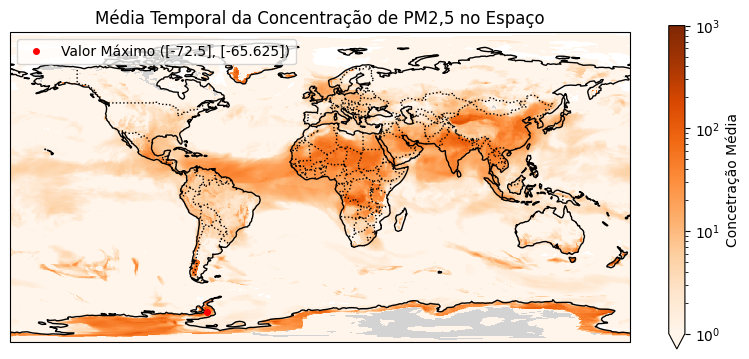

In [9]:
#Criando figura das médias no tempo e plotando o ponto máximo

norm = LogNorm(vmin=1, vmax=1000) #utilizando escala logaritima

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plotar os dados

mediatime.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Oranges', norm=norm,cbar_kwargs={'shrink':0.7,'label':'Concetração Média'})
ax.plot(lon, lat, 'ro', markersize=4,color='red', label=f'Valor Máximo ({lat}, {lon})')
ax.legend(loc='upper left')
# Adicionar o mapa-múndi com costas e fronteiras
ax.coastlines()  # Desenhar as linhas costeiras
ax.add_feature(cfeature.BORDERS, linestyle=':')  # Adicionar fronteiras dos países
ax.add_feature(cfeature.LAND, facecolor='lightgray')  # Adicionar continentes em cinza claro
plt.title('Média Temporal da Concentração de PM2,5 no Espaço')
plt.show()

### Tentativa de recorte dos dados do Brasil

In [10]:
# Definir os limites para o Brasil
lat_min, lat_max = -35, 6
lon_min, lon_max = -75, -34

# Recortar os dados para o Brasil usando .sel()
brasil = pm25.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
print(brasil.dims)
print(brasil.data_vars)
print(pm25.lat.min().values, pm25.lat.max().values)
print(pm25.lon.min().values, pm25.lon.max().values)
print(lat_min)
brasil
mediatimebrasil = brasil['MERRA2_CNN_Surface_PM25'].mean(dim='time') # calculando a média no tempo

FrozenMappingWarningOnValuesAccess({'time': 48, 'lat': 83, 'lon': 66})
Data variables:
    MERRA2_CNN_Surface_PM25  (time, lat, lon) float32 1MB 0.0 0.0 ... 17.2 18.66
    QFLAG                    (time, lat, lon) float64 2MB 2.0 2.0 ... 2.0 2.0
-90.0 90.0
-180.0 179.375
-35


<xarray.DataArray 'MERRA2_CNN_Surface_PM25' (lat: 83, lon: 66)> Size: 22kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 332B -35.0 -34.5 -34.0 -33.5 ... 4.5 5.0 5.5 6.0
  * lon      (lon) float32 264B -75.0 -74.38 -73.75 ... -35.62 -35.0 -34.38


array([ 5,  6,  7,  7,  7,  7,  5,  6,  6,  6,  6,  6,  6, 39, 39,  7, 38,
       37, 38, 38, 40, 45, 45,  8,  8, 49, 49, 49, 18, 19, 19, 19, 50, 50,
       18, 17, 51, 51, 42, 52, 52, 11, 44, 53, 53, 47,  3, 52,  1,  1,  1,
       20, 18, 18, 18, 13, 12, 12, 22, 22, 22, 65, 18, 17, 17, 62, 14, 63,
       63, 63, 63, 65, 65, 64, 58, 60, 60, 46, 48, 22, 21, 41, 42])

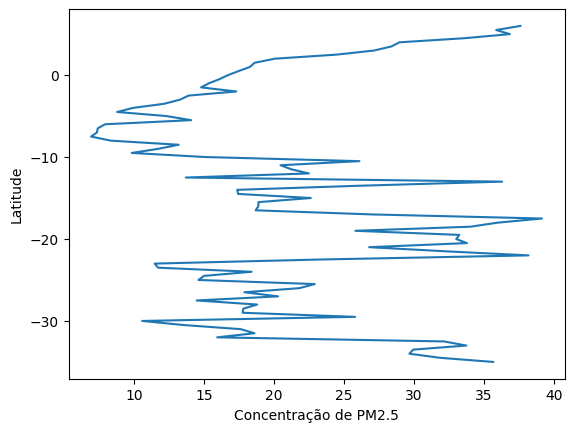

In [24]:
max_mediatimebrasil = mediatimebrasil.max(dim='lon') #calculando o valor máximo na dimensão longitude

#plotando as máximas
fig,ax= plt.subplots()
ax.plot(max_mediatimebrasil, max_mediatimebrasil['lat'][:])
plt.xlabel('Concentração de PM2.5')
plt.ylabel('Latitude')

#verificando a linha em que se encontra os valores máximos
resultbra = mediatimebrasil.where(mediatimebrasil == max_mediatimebrasil)
print(resultbra)
resultado = np.array([np.where(~np.isnan(row))[0][0] for row in resultbra])
resultado


In [25]:
resultado2 = -75+0.625*resultado #convertendo os valores das linhas em latitude

#### Plotando gráfico com as médias no tempo e os valores máximos por latitude

C:\Users\BiaBN\AppData\Local\Temp\ipykernel_20740\1144133973.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(resultado2, mediatimebrasil.lat, 'ro',markersize=4,color='red', label='Valores Máximos por Latitude')


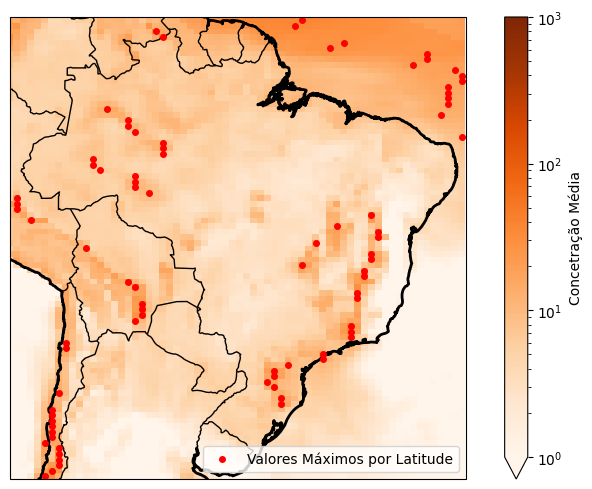

In [27]:
mediatimebrasil = brasil['MERRA2_CNN_Surface_PM25'].mean(dim='time')

norm = LogNorm(vmin=1, vmax=1000)
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plotar os dados

mediatimebrasil.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Oranges', norm=norm,cbar_kwargs={'shrink':1,'label':'Concetração Média'})
ax.plot(resultado2, mediatimebrasil.lat, 'ro',markersize=4,color='red', label='Valores Máximos por Latitude')

ax.coastlines(resolution='10m', linewidth=2)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.legend(loc='lower right')
# Definir a extensão do mapa para o Brasil
ax.set_extent([lon_min, lon_max, lat_min+1.5, lat_max+0.3])
plt.show()

### Recortando os dados somente para o Brasil usando o shapefile do IBGE

In [28]:
xds = xr.open_mfdataset(prefixed)
pm25 = xds['MERRA2_CNN_Surface_PM25'][:]
shapefile = gpd.read_file(r'C:\Users\BiaBN\OneDrive\Documentos\ENS410064\Dados\BR_Pais_2022\BR_Pais_2022.shp')

da0 = xr.DataArray(
      data = pm25,
      dims = ["time","y","x"],
      coords = dict(
            x = (["x"], xds['lon'].to_numpy()),
            y = (["y"], xds['lat'].to_numpy()),
      )
)
da = da0.rio.write_crs("epsg:4326", inplace=True)
geodf = shapefile.copy()
clipped = da.rio.clip(geodf.geometry.apply(mapping), geodf.crs,drop=False)
clipped.to_netcdf('ClipBR.nc')
print(clipped)
mediaclipped = clipped.mean(dim='time')
mediaclipped = mediaclipped.compute()
clipped_clean = mediaclipped.where(~np.isnan(mediaclipped), drop=True) #retirando nan
print(clipped_clean)

<xarray.DataArray 'MERRA2_CNN_Surface_PM25' (time: 48, y: 361, x: 576)> Size: 40MB
dask.array<where, shape=(48, 361, 576), dtype=float32, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float32 2kB -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * y            (y) float32 1kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
    spatial_ref  int64 8B 0
Dimensions without coordinates: time
Attributes:
    units:      ug m-3
    long_name:  Bias corrected surface total PM2.5 mass concentration
<xarray.DataArray 'MERRA2_CNN_Surface_PM25' (y: 78, x: 63)> Size: 20kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float32 252B -73.75 -73.12 -72.5 ... -36.25 -35.62 -35.0
  * y            (

### Calculando os valores máximos por latitude

In [29]:
clipped_max = clipped_clean.max(dim='x') #valores máximos por latitude
print(clipped_max)
resultbrasil = clipped_clean.where(clipped_clean == clipped_max)
print(resultbrasil)
resultado1 = np.array([np.where(~np.isnan(row))[0][0] for row in resultbrasil])
resultado02 = -73.75+0.625*resultado1
print(resultado1)

<xarray.DataArray 'MERRA2_CNN_Surface_PM25' (y: 78)> Size: 312B
array([ 1.9276329,  3.2317924,  4.123731 ,  4.9875093,  5.376949 ,
        5.8827157,  6.7068458,  6.0637918,  7.47415  , 10.627975 ,
       17.794735 , 18.785841 , 13.959987 , 20.280449 , 17.871658 ,
       21.802351 , 22.898352 , 14.5861845, 13.012856 , 18.388527 ,
       10.458463 ,  9.410071 , 23.390802 , 38.18146  , 32.242    ,
       16.496252 , 19.055485 , 15.86658  , 17.92428  , 25.80848  ,
       34.020943 , 29.334442 , 23.246527 , 26.95452  , 18.67828  ,
       18.872091 , 18.878565 , 22.621271 , 14.605179 , 17.35903  ,
       26.101038 , 36.30149  , 13.683456 , 22.200155 , 21.236969 ,
        8.904546 , 15.5124445, 11.415187 ,  9.818755 , 11.702392 ,
       13.175809 ,  8.324157 ,  6.911062 ,  7.3307557,  7.388162 ,
        7.9077873, 14.063713 , 12.308601 ,  8.224454 ,  9.923991 ,
       12.137124 , 13.268054 , 13.262799 , 17.291525 , 11.292244 ,
       11.374779 , 10.45095  , 11.199803 ,  8.748276 ,  9.114632 

#### Plotando no mapa

C:\Users\BiaBN\AppData\Local\Temp\ipykernel_20740\2403920241.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax[ii].plot(resultado02, clipped_clean.y, 'ro',markersize=4,color='r', label='Valores Máximos \n por Latitude')
C:\Users\BiaBN\AppData\Local\Temp\ipykernel_20740\2403920241.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax[ii].plot(resultado02, clipped_clean.y, 'ro',markersize=4,color='r', label='Valores Máximos \n por Latitude')


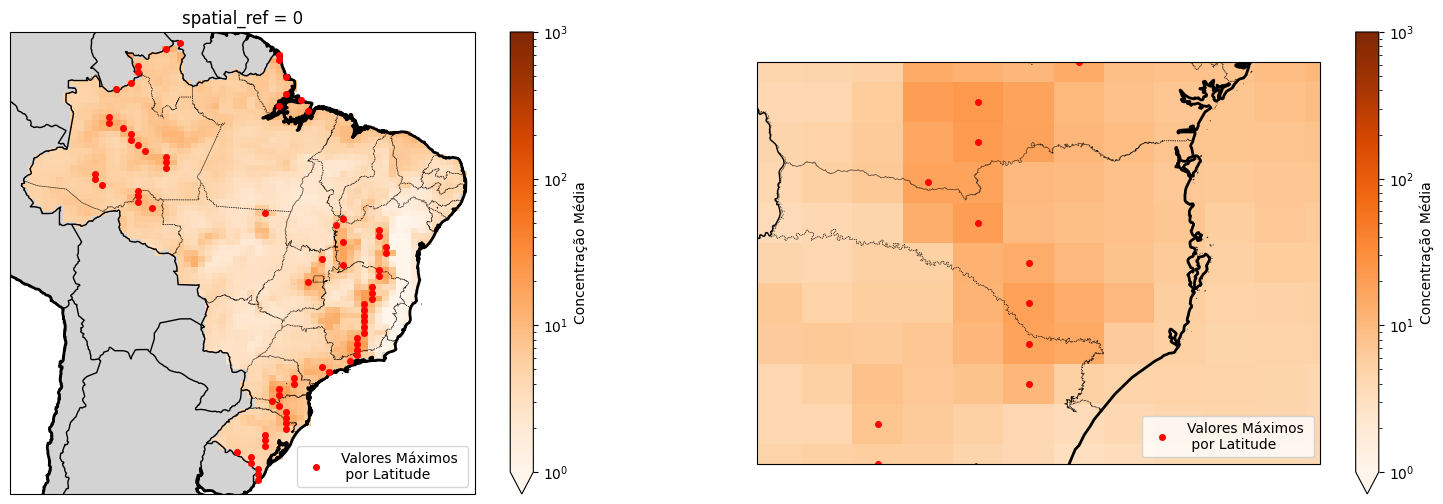

In [30]:
shapefile1 = gpd.read_file(r"C:\Users\BiaBN\OneDrive\Documentos\ENS410064\Dados\BR_UF_2022\BR_UF_2022.shp")
limites_santa_catarina = [-47,-54,-25,-30]

fig, ax = plt.subplots(1,2,figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})

for ii in range(2):
    if ii == 0:
        clipped_clean.plot(ax=ax[ii], cmap='Oranges', norm=norm, cbar_kwargs={'shrink': 1, 'label': 'Concentração Média'}) 
    else:
        mediatimebrasil.plot(ax=ax[ii], cmap='Oranges', norm=norm,cbar_kwargs={'label': 'Concentração Média'})
    ax[ii].plot(resultado02, clipped_clean.y, 'ro',markersize=4,color='r', label='Valores Máximos \n por Latitude')
    ax[ii].coastlines(resolution='10m', linewidth=2)
    ax[ii].add_feature(cfeature.BORDERS, linewidth=1)
    ax[ii].add_feature(cfeature.LAND, facecolor='lightgrey')
    ax[ii].add_geometries(shapefile1.geometry, crs=ccrs.PlateCarree(), edgecolor='black', linestyle=':', facecolor='none', linewidth=0.5)
    ax[ii].legend(loc='lower right')
    # Definir a extensão do mapa para o Brasil
    ax[0].set_extent([lon_min, lon_max, lat_min+2, lat_max])
    ax[1].set_extent(limites_santa_catarina)

In [31]:
max_bra_lon = float(clipped_max.max())
min_bra_lon=float(clipped_max.min())
print(f'Os valores máximos em cada latitude variam de {min_bra_lon:.2f} até {max_bra_lon:.2f} μg/m³.')

Os valores máximos em cada latitude variam de 1.93 até 38.18 μg/m³.


#### PLotando em corte

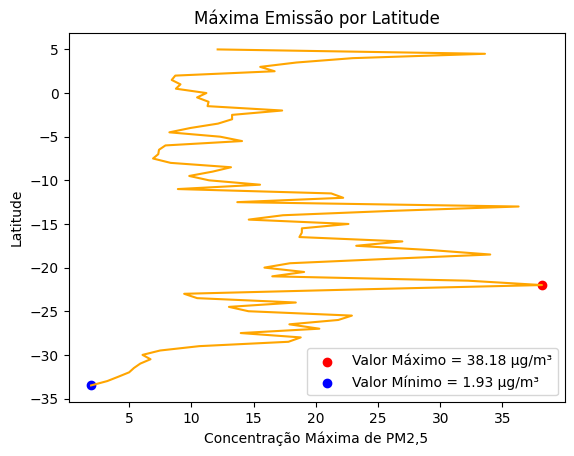

In [32]:
fig,ax= plt.subplots()
ax.plot(clipped_max, clipped_clean['y'][:], color='orange')
ax.scatter(clipped_max.max(), -33.5+0.5*23, color='red', label=f'Valor Máximo = {max_bra_lon:.2f} μg/m³' )
ax.scatter(clipped_max.min(), -33.5+0.5*0, color='blue', label=f'Valor Mínimo = {min_bra_lon:.2f} μg/m³' )
ax.set_title("Máxima Emissão por Latitude")
ax.set_xlabel("Concentração Máxima de PM2,5")
ax.set_ylabel("Latitude")
ax.legend(loc='lower right')

### Verificando a concentração no pixel que inclui Florianópolis

C:\Users\BiaBN\AppData\Local\Temp\ipykernel_20740\3576337045.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time = pd.date_range(start='2024-05-05', periods=len(time_steps), freq='H')


DatetimeIndex(['2024-05-05 00:00:00', '2024-05-05 01:00:00',
               '2024-05-05 02:00:00', '2024-05-05 03:00:00',
               '2024-05-05 04:00:00', '2024-05-05 05:00:00',
               '2024-05-05 06:00:00', '2024-05-05 07:00:00',
               '2024-05-05 08:00:00', '2024-05-05 09:00:00',
               '2024-05-05 10:00:00', '2024-05-05 11:00:00',
               '2024-05-05 12:00:00', '2024-05-05 13:00:00',
               '2024-05-05 14:00:00', '2024-05-05 15:00:00',
               '2024-05-05 16:00:00', '2024-05-05 17:00:00',
               '2024-05-05 18:00:00', '2024-05-05 19:00:00',
               '2024-05-05 20:00:00', '2024-05-05 21:00:00',
               '2024-05-05 22:00:00', '2024-05-05 23:00:00',
               '2024-05-06 00:00:00', '2024-05-06 01:00:00',
               '2024-05-06 02:00:00', '2024-05-06 03:00:00',
               '2024-05-06 04:00:00', '2024-05-06 05:00:00',
               '2024-05-06 06:00:00', '2024-05-06 07:00:00',
               '2024-05-

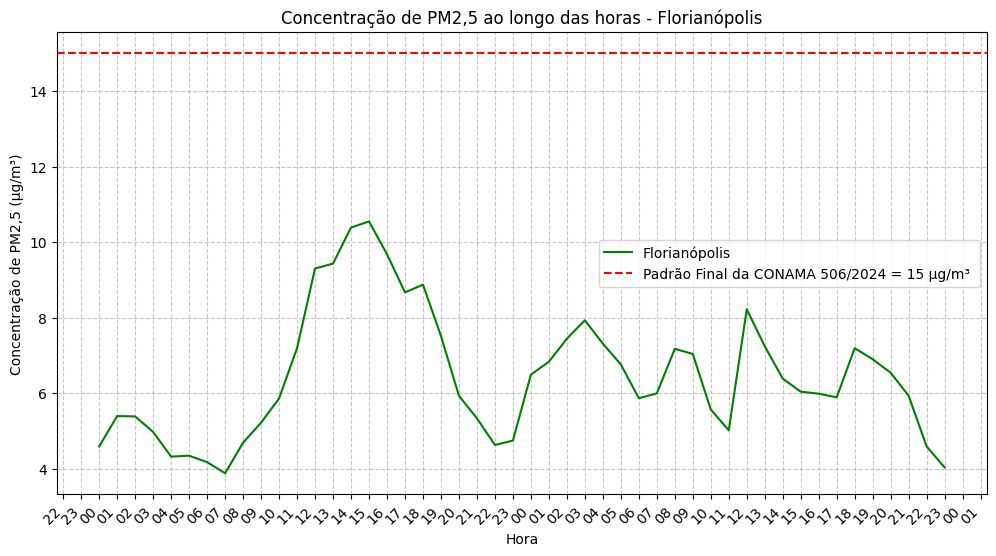

In [33]:


x_idx = np.abs(clipped.x - (-48.5491)).argmin()  # Índice da longitude mais próxima
y_idx = np.abs(clipped.y - (-27.5966)).argmin()  # Índice da latitude mais próxima

# Extrair os dados de 'clipped' para essa localização ao longo do tempo
clipped_floripa = clipped.sel(x=clipped.x[x_idx], y=clipped.y[y_idx])
time_steps = clipped.time.values
time = pd.date_range(start='2024-05-05', periods=len(time_steps), freq='H')
print(time)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, clipped_floripa, color='green', label='Florianópolis')
plt.axhline(y= 15, color= 'red', linestyle='--', label='Padrão Final da CONAMA 506/2024 = 15 μg/m³ ')
ax.set_xlabel('Hora')
ax.set_ylabel('Concentração de PM2,5 (µg/m³)')
ax.set_title('Concentração de PM2,5 ao longo das horas - Florianópolis')
ax.legend(loc = 7)
ax.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Formatar o eixo x para mostrar horas
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Ticks a cada 1 hora
ax.tick_params(axis='x', rotation=45)
plt.setp(ax.get_xticklabels(), ha='right')
plt.show()

### Recortando dados de Santa Catarina

In [34]:
shapeSC = gpd.read_file(r"C:\Users\BiaBN\OneDrive\Documentos\ENS410064\Dados\SC_UF_2022\SC_UF_2022.shp")
geodfSC = shapeSC.copy()
clippedSC = da.rio.clip(geodfSC.geometry.apply(mapping), geodfSC.crs,drop=False)
clippedSC.to_netcdf('ClipSC.nc')
clippedSC = clippedSC.compute()
clipped_cleanSC = clippedSC.where(~np.isnan(clippedSC), drop=True)
print(clipped_cleanSC)

<xarray.DataArray 'MERRA2_CNN_Surface_PM25' (time: 48, y: 6, x: 8)> Size: 9kB
array([[[       nan,        nan,        nan, ...,        nan,
          4.4687767,  4.3552656],
        [       nan,        nan,        nan, ..., 22.159634 ,
         10.466967 ,  3.9144986],
        [       nan,        nan,        nan, ...,  6.7700443,
          6.777502 ,  4.5855646],
        [ 5.911017 ,  7.721184 , 30.734352 , ...,  8.031184 ,
          6.7477474,  4.8119926],
        [12.500804 , 11.140089 ,        nan, ...,  9.504165 ,
          7.04247  ,  5.737521 ],
        [       nan,        nan,        nan, ...,        nan,
                nan,  7.4239817]],

       [[       nan,        nan,        nan, ...,        nan,
          4.305635 ,  4.460331 ],
        [       nan,        nan,        nan, ..., 12.551849 ,
         11.0029335,  5.5067077],
        [       nan,        nan,        nan, ...,  5.645538 ,
          7.563546 ,  5.39043  ],
        [ 6.410301 ,  7.4532566, 34.547432 , ...,  8.599

#### Calculando a máxima média no tempo

In [35]:
SC_media = clipped_cleanSC.mean(dim='time')
SC_mediamax = SC_media.max()
print(SC_mediamax)


<xarray.DataArray 'MERRA2_CNN_Surface_PM25' ()> Size: 8B
array(20.28044701)
Coordinates:
    spatial_ref  int64 8B 0


In [36]:
# descobrindo a latitude e longitude da máxima

max_location = SC_media.where(SC_media == SC_mediamax, drop=True)
latitude_max = max_location.y.values[0]
longitude_max = max_location.x.values[0]
print(latitude_max)
print(longitude_max)


-27.0
-51.25


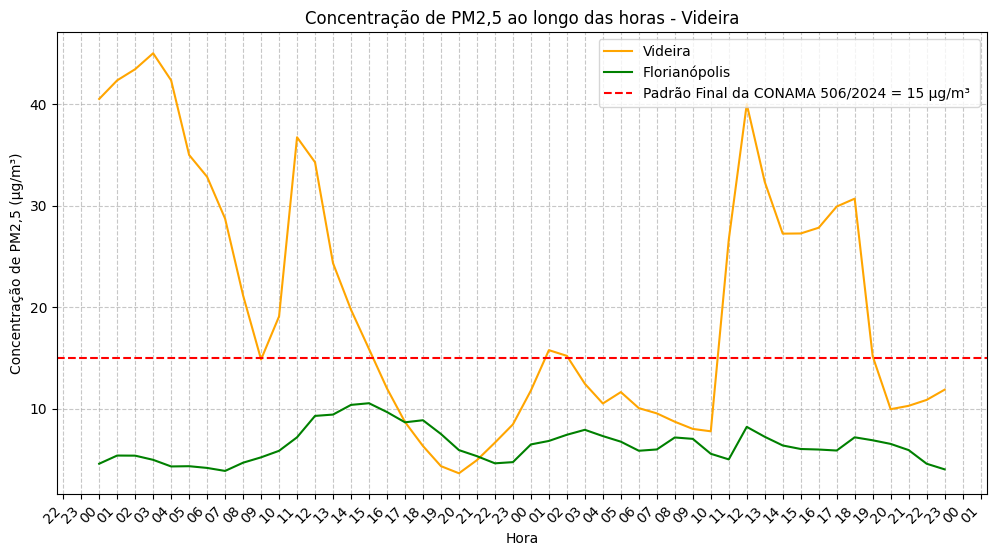

In [37]:
x_idx = np.abs(clippedSC.x - (-51.25)).argmin()  # Índice da longitude mais próxima
y_idx = np.abs(clippedSC.y - (-27)).argmin()  # Índice da latitude mais próxima

clipped_max = clippedSC.sel(x=clippedSC.x[x_idx], y=clippedSC.y[y_idx])
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, clipped_max, color='orange', label='Videira')
ax.plot(time, clipped_floripa, color='green', label='Florianópolis')
plt.axhline(y= 15, color= 'red', linestyle='--', label='Padrão Final da CONAMA 506/2024 = 15 μg/m³ ')
ax.set_xlabel('Hora')
ax.set_ylabel('Concentração de PM2,5 (µg/m³)')
ax.set_title('Concentração de PM2,5 ao longo das horas - Videira')
ax.legend(loc = 'upper right')
ax.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Formatar o eixo x para mostrar horas
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Ticks a cada 1 hora
ax.tick_params(axis='x', rotation=45)
plt.setp(ax.get_xticklabels(), ha='right')
plt.show()